# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [23]:
! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prophet lightgbm EMD-signal tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import itertools
import logging
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PyEMD import EEMD

import os, joblib, importlib
import comparison_utils
importlib.reload(comparison_utils)

from comparison_utils import create_styled_excel
import openpyxl

import tensorflow as tf

import keras
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox, norm

# Deep learning
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2


from prophet import Prophet
# Disable Prophet logs
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import lightgbm as lgb
# Optional: Disable LightGBM info messages
lgb.basic_config = {'verbose': -1}

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [25]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Disable TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Importing Final Datasts

In [26]:
# Folder containing the datasets
input_folder = Path("final_datasets")

# Dictionary to hold the loaded DataFrames
loaded_dfs = {}

# Loop through all Excel files except 'final_df.xlsx'
for file in input_folder.glob("*.xlsx"):
    if file.name == "final_df.xlsx":
        continue
    
    # Use the filename without extension as the variable name
    var_name = file.stem
    loaded_dfs[var_name] = pd.read_excel(file, index_col=0)  # preserve index if any

# Optionally, assign to variables in global namespace (careful with this in scripts)
globals().update(loaded_dfs)

# Check loaded DataFrames
print("Loaded datasets:")
for name, df in loaded_dfs.items():
    print(f"- {name}: {df.shape}")

Loaded datasets:
- X1_test: (41, 13)
- X1_train: (213, 13)
- X2_test: (41, 10)
- X2_train: (213, 10)
- y1_test: (41, 1)
- y1_train: (213, 1)
- y2_test: (41, 1)
- y2_train: (213, 1)


In [27]:
X1_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2021-12-31 to 2025-04-30
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   autotrader_queries_top                  41 non-null     float64
 1   vw_queries_top                          41 non-null     float64
 2   cars_for_sale_queries_top               41 non-null     float64
 3   toyota_corolla_for_sale_queries_rising  41 non-null     float64
 4   webuycars_queries_rising                41 non-null     float64
 5   toyota_queries_top                      41 non-null     float64
 6   opel_queries_top                        41 non-null     float64
 7   toyota_topics_top                       41 non-null     float64
 8   honda_queries_top                       41 non-null     float64
 9   gwm_queries_rising                      41 non-null     float64
 10  audi_topics_top                         41 n

In [28]:
# Folder containing the scalers
input_folder = Path("final_scalers")

# Load fitted scalers back
X1_scaler = joblib.load(input_folder / "X1_scaler.pkl")
X2_scaler = joblib.load(input_folder / "X2_scaler.pkl")
y1_scaler = joblib.load(input_folder / "y1_scaler.pkl")
y2_scaler = joblib.load(input_folder / "y2_scaler.pkl")

print("Scalers loaded successfully.")

Scalers loaded successfully.


## 3. Ensemble Empirical Mode Decomposition (EEMD)

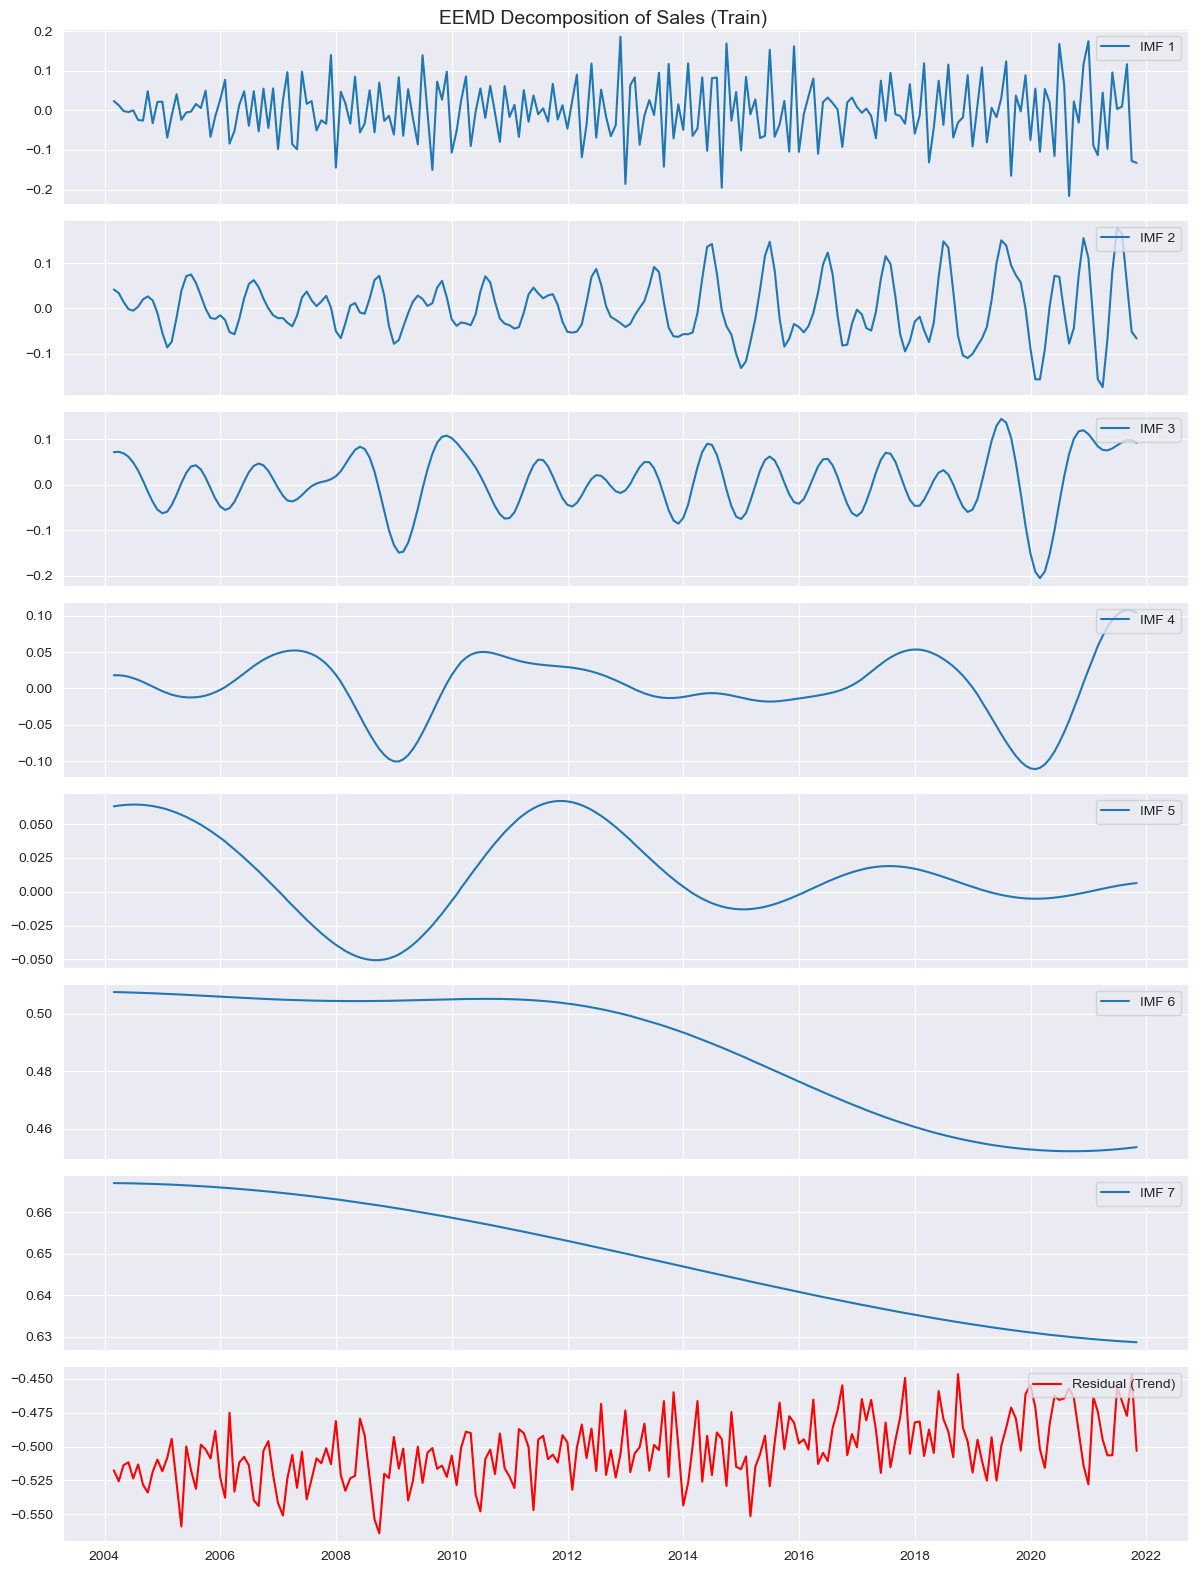

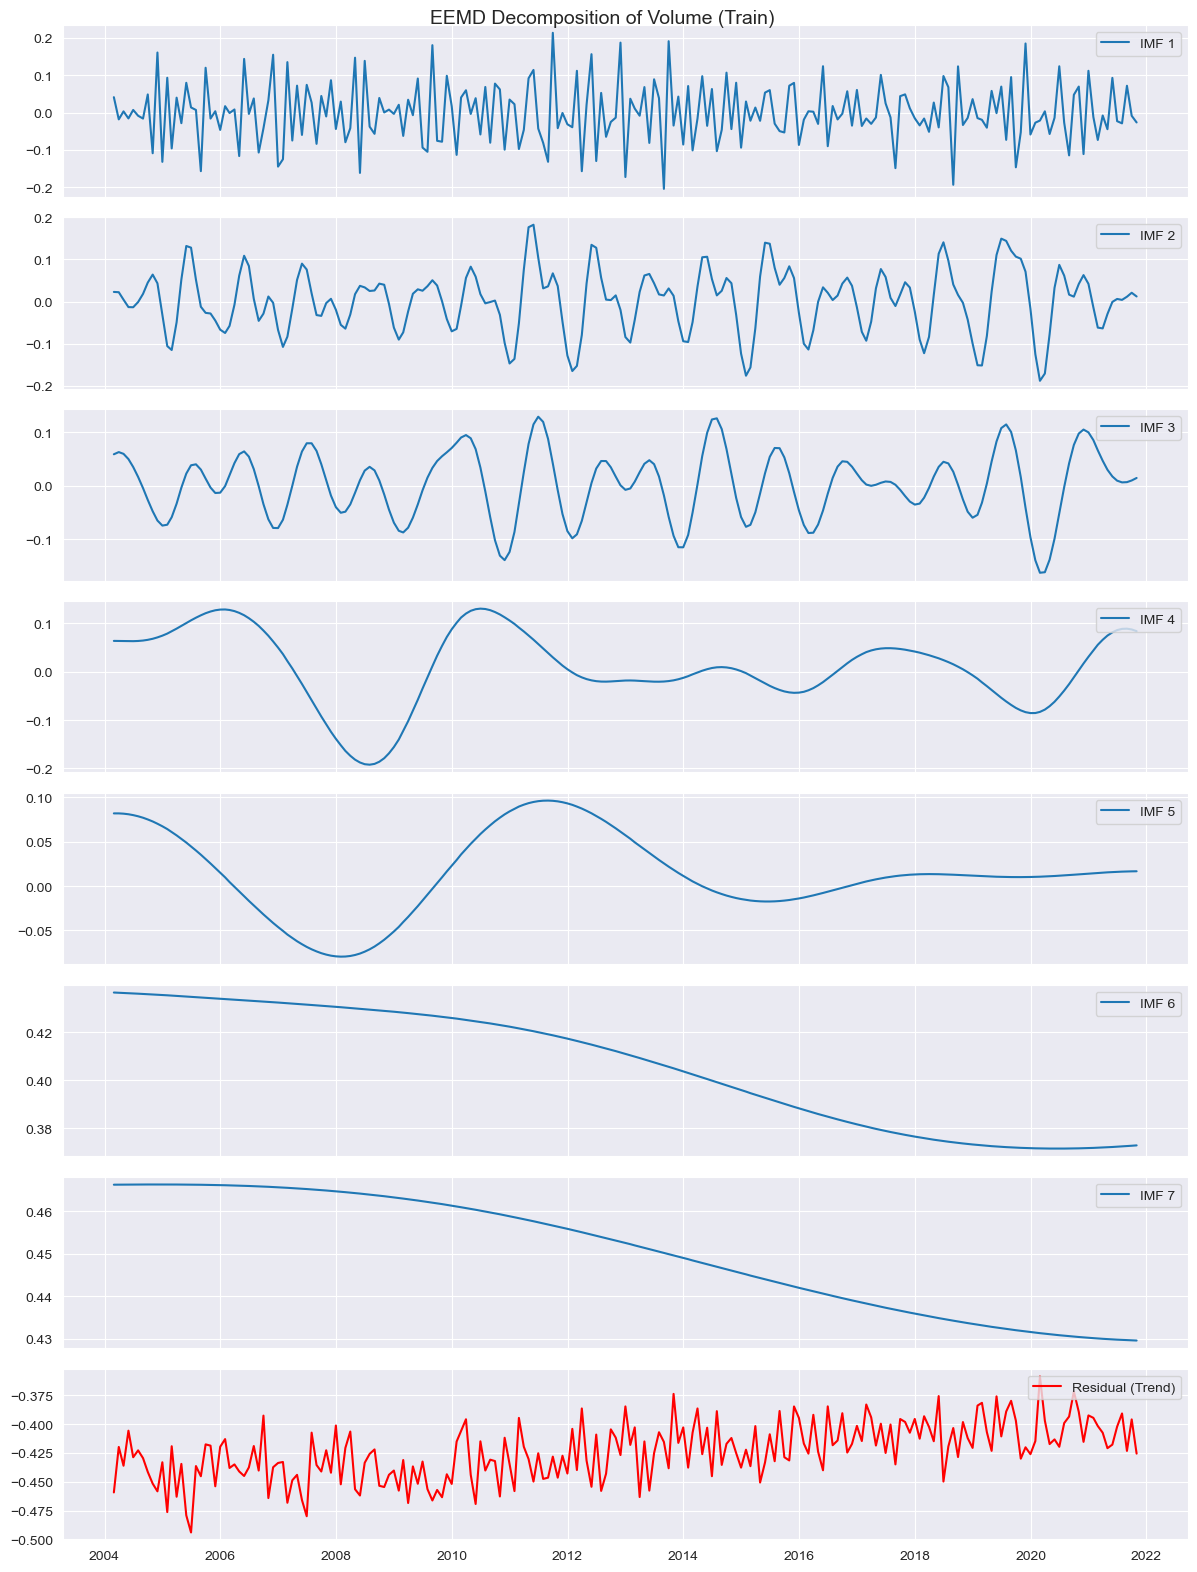

In [29]:
# === EEMD to create Intrinsic Mode Functions (IMFs) ===
def run_eemd(series, series_name="Series", noise_width=0.2, n_ensembles=100, max_imf=8, plot=True):
    """
    Decompose training series using EEMD.
    Returns IMFs (n_imfs, len(series)) and residual.
    """
    eemd = EEMD()
    eemd.noise_width = noise_width
    eemd.trials = n_ensembles

    series = series.dropna()
    X = series.values.flatten()
    t = np.arange(len(series))

    imfs = eemd.eemd(X, t, max_imf)
    residual = X - np.sum(imfs, axis=0)

    if plot:
        n_imfs = imfs.shape[0]
        fig, axes = plt.subplots(n_imfs+1, 1, figsize=(12, 2*(n_imfs+1)), sharex=True)
        for i in range(n_imfs):
            axes[i].plot(series.index, imfs[i], label=f'IMF {i+1}')
            axes[i].legend(loc='upper right')
        axes[-1].plot(series.index, residual, label="Residual (Trend)", color="red")
        axes[-1].legend(loc='upper right')
        plt.suptitle(f"EEMD Decomposition of {series_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

    return imfs, residual


# Example decomposition
sales_imfs, sales_residual = run_eemd(y1_train, "Sales (Train)")
volume_imfs, volume_residual = run_eemd(y2_train, "Volume (Train)")

eemd_results = {
    "sales": {"imfs": sales_imfs, "residual": sales_residual},
    "volume": {"imfs": volume_imfs, "residual": volume_residual}
}


## 4. Lag Selection and ARX Preparation

In [80]:
# === Lagged Feature Creator ===
def create_features(y_train, y_test, X_train, X_test, lags, series_name):
    """Generate lagged features + align train/test with exogenous features."""
    # Train lags
    lagged_train = pd.DataFrame(index=y_train.index)
    for lag in range(1, lags + 1):
        lagged_train[f"{series_name}_lag{lag}"] = y_train.shift(lag)
    X_train = pd.concat([lagged_train, X_train], axis=1).dropna()
    y_train = y_train.loc[X_train.index]

    # Test lags (use last lags from train to seed)
    combined = pd.concat([y_train.tail(lags), y_test])
    lagged_test = pd.DataFrame(index=combined.index)
    for lag in range(1, lags + 1):
        lagged_test[f"{series_name}_lag{lag}"] = combined.shift(lag)
    lagged_test = lagged_test.iloc[lags:]
    
    X_test = pd.concat([lagged_test.reset_index(drop=True),
                        X_test.reset_index(drop=True)], axis=1)
    y_test = y_test.reset_index(drop=True).iloc[:len(X_test)]

    return X_train, X_test, y_train, y_test


# Apply with correct lag structure
X1_train_lagged, X1_test_lagged, y1_train_lagged, y1_test_lagged = create_features(y1_train, y1_test, X1_train, X1_test, lags=1, series_name="Sales")
X2_train_lagged, X2_test_lagged, y2_train_lagged, y2_test_lagged = create_features(y2_train, y2_test, X2_train, X2_test, lags=2, series_name="Volume")

## 5. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA / SARIMAX</td>
      <td>Captures linear seasonality and trend but limited in handling nonlinear patterns.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>Least Squares SVM regression. Strong at capturing nonlinear relationships, though it requires careful hyperparameter tuning.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>Sequential neural model for time series. Learns long-term dependencies and nonlinearities but can be computationally heavy.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BiLSTM</td>
      <td>Captures both forward and backward dependencies in sequences, offering richer temporal context than unidirectional LSTM.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines CNN (local feature extraction) with LSTM (temporal learning). Effective for complex time series with both short- and long-term dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>GRU</td>
      <td>A simplified version of LSTM with fewer parameters. Trains faster while retaining the ability to model temporal dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>Prophet</td>
      <td>Additive time series model developed by Facebook. Designed for business forecasting, handles seasonality, holidays, and missing data robustly.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>Gradient boosting framework optimized for speed and efficiency. Handles high-dimensional data well, supports feature importance analysis, and is strong at capturing nonlinear interactions.</td>
      <td>Machine Learning</td>
    </tr>
  </tbody>
</table>


### a. Determining Sarima Order

In [31]:
def fit_sarimax_and_forecast(y_train, X_train=None, X_forecast=None,
                             order=(1,1,0), seasonal_order=(0,0,0,0),
                             trend='c', steps=None):
    """
    Fit SARIMAX and return fitted results, forecast mean and conf_int DataFrame.
    y_train: pd.Series (train)
    X_train: pd.DataFrame or None (aligned to y_train)
    X_forecast: pd.DataFrame or None (exog for forecast horizon length)
    order, seasonal_order: SARIMAX orders
    trend: 'c'|'t'|None etc.
    steps: integer forecast horizon (if None and X_forecast provided then len(X_forecast))
    """
    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    if steps is None:
        steps = len(X_forecast) if X_forecast is not None else 0
    if steps == 0:
        # nothing to forecast
        return res, None, None
    # If exog for forecast provided, pass it; else forecast without exog
    forecast_obj = res.get_forecast(steps=steps, exog=X_forecast)
    pred = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()
    # ensure index for pred/ci: create a datetime index if y_train has datetime and X_forecast has index
    if X_forecast is not None and hasattr(X_forecast, "index"):
        pred.index = X_forecast.index[:len(pred)]
        ci.index = X_forecast.index[:len(ci)]
    else:
        # fallback: create RangeIndex starting after y_train
        start_idx = y_train.index[-1] if hasattr(y_train.index, 'dtype') and np.issubdtype(y_train.index.dtype, np.datetime64) else None
        # if we can't set, leave as is
    return res, pred, ci

def compare_sarimax_candidates(y_train, y_test, X_train=None, X_test=None, candidates=None):
    """
    Fit multiple SARIMAX candidates and return a small table comparing AIC/BIC/RMSE.
    candidates: list of dicts with keys 'order','seasonal_order','trend','name'
    """
    rows = []
    for c in candidates:
        res, pred, ci = fit_sarimax_and_forecast(y_train, X_train=X_train, X_forecast=X_test,
                                                order=c['order'], seasonal_order=c.get('seasonal_order',(0,0,0,0)),
                                                trend=c.get('trend','c'))
        if pred is None:
            continue
        # align y_test and pred
        y_true = y_test.values.flatten()
        y_hat = pred.values.flatten()[:len(y_true)]
        rmse = np.sqrt(np.mean((y_true - y_hat)**2))
        rows.append({
            "name": c.get('name'),
            "order": c['order'],
            "seasonal_order": c.get('seasonal_order'),
            "trend": c.get('trend','c'),
            "AIC": round(getattr(res, 'aic', np.nan), 3),
            "RMSE": round(rmse, 3)
        })
    return pd.DataFrame(rows).sort_values("RMSE")

In [32]:
# Determining which Sarimax model order to use
sales_candidates = [
    {"name":"Sales_ARIMA110_drift", "order":(1,1,0), "seasonal_order":(0,0,0,0), "trend":"t"},
    {"name":"Sales_ARIMA110_seasonalMA", "order":(1,1,0), "seasonal_order":(0,0,1,12), "trend":"t"},
    {"name":"Sales_ARIMA110_seasonalDiffMA", "order":(1,1,0), "seasonal_order":(0,1,1,12), "trend":"t"},
]

sales_table = compare_sarimax_candidates(y1_train_lagged, y1_test_lagged, X_train=X1_train_lagged, X_test=X1_test_lagged, candidates=sales_candidates)
sales_table

# Result: Model 1 (Sales_ARIMA110_seasonalMA) is the best when compared

,name,order,seasonal_order,trend,AIC,RMSE
1,Sales_ARIMA110_seasonalMA,"(1, 1, 0)","(0, 0, 1, 12)",t,-217.989,0.291
0,Sales_ARIMA110_drift,"(1, 1, 0)","(0, 0, 0, 0)",t,-226.886,0.314
2,Sales_ARIMA110_seasonalDiffMA,"(1, 1, 0)","(0, 1, 1, 12)",t,-205.327,0.340


In [33]:
# Volume
volume_candidates = [
    {"name":"Volume_AR2_const", "order":(2,0,0), "seasonal_order":(0,0,0,0), "trend":"c"},
    {"name":"Volume_AR2_seasonalMA", "order":(2,0,0), "seasonal_order":(0,0,1,12), "trend":"c"},
    {"name":"Volume_AR2_seasonalDiffMA", "order":(2,0,0), "seasonal_order":(0,1,1,12), "trend":"c"},
]

volume_table = compare_sarimax_candidates(y2_train_lagged, y2_test_lagged, X_train=X2_train_lagged, X_test=X2_test_lagged, candidates=volume_candidates)
volume_table

# Result: Model 2 (Volume_AR2_seasonalDiffMA) is the best 

,name,order,seasonal_order,trend,AIC,RMSE
1,Volume_AR2_seasonalMA,"(2, 0, 0)","(0, 0, 1, 12)",c,-214.869,0.118
0,Volume_AR2_const,"(2, 0, 0)","(0, 0, 0, 0)",c,-226.123,0.119
2,Volume_AR2_seasonalDiffMA,"(2, 0, 0)","(0, 1, 1, 12)",c,-218.310,0.131


### b. Helper Functions

In [34]:
# ============================================================================
# EVALUATION
# ============================================================================
def evaluate_model(y_true, y_pred, model_name="Model",
                   fitted_model=None, conf_int=None, k=None):
    """Compute metrics (RMSE, MAE, MAPE, R2, AIC, BIC)."""
    if hasattr(y_true, "index"):
        index = y_true.index
        y_true = y_true.values.flatten()
    else:
        index = pd.RangeIndex(start=0, stop=len(y_true))
        y_true = np.array(y_true).flatten()

    y_pred = np.array(y_pred).flatten()
    residuals = y_true - y_pred
    rss, n = np.sum(residuals**2), len(y_true)

    rmse = np.sqrt(rss / n)
    mae = np.mean(np.abs(residuals))
    mape = np.mean(np.abs(residuals / (y_true + 1e-10)))
    r2 = 1 - rss / np.sum((y_true - np.mean(y_true))**2)

    aic, bic = np.nan, np.nan
    if fitted_model is not None and hasattr(fitted_model, "aic") and hasattr(fitted_model, "bic"):
        aic, bic = fitted_model.aic, fitted_model.bic
    else:
        if k is None:
            k = 1
        aic = n * np.log(rss / n) + 2 * k
        bic = n * np.log(rss / n) + k * np.log(n)

    if conf_int is not None:
        ci_lower, ci_upper = conf_int[:, 0], conf_int[:, 1]
    else:
        ci_lower, ci_upper = np.full_like(y_pred, np.nan), np.full_like(y_pred, np.nan)

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }, index=index)

    metrics = {
        "Model": model_name,
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "MAPE": round(mape, 3),
        "R2": round(r2, 3),
        "AIC": round(aic, 3) if not np.isnan(aic) else np.nan,
        "BIC": round(bic, 3) if not np.isnan(bic) else np.nan
    }
    return metrics, df


# ============================================================================
# CLASSICAL & ML MODEL TRAINERS
# ============================================================================
def train_sarimax(y_train, X_train=None, order=(1,1,0), seasonal_order=(0,0,0,0)):
    """SARIMAX (or ARIMA if X_train=None)."""
    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
    return model.fit(disp=False)


def train_lightgbm(X_train, y_train, params=None):
    """LightGBM regressor."""
    if params is None:
        params = {"objective": "regression", "n_estimators": 200, "learning_rate": 0.05, "verbose": -1}
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return model


def train_lssvr(X_train, y_train, C=1.0, gamma="scale"):
    """Approximate LSSVR with sklearn SVR."""
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    return model


def train_prophet(y_train, X_train=None):
    """Prophet with or without exogenous regressors."""
    df = y_train.reset_index()
    df.columns = ["ds", "y"]
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    if X_train is not None:
        for col in X_train.columns:
            model.add_regressor(col)
        df = pd.concat([df, X_train.reset_index(drop=True)], axis=1)
    model.fit(df)
    return model


# ============================================================================
# DEEP LEARNING HELPERS
# ============================================================================
def create_sequences(X, y, seq_length=12):
    """Create proper time series sequences for LSTM/GRU training."""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq).flatten()


def build_lstm(input_shape, units=32, dropout_rate=0.2, l2_lambda=1e-4, 
               n_layers=1, learning_rate=1e-3):
    """Simplified LSTM."""
    model = Sequential()
    if n_layers == 1:
        model.add(LSTM(units, activation="tanh", return_sequences=False,
                      kernel_regularizer=l2(l2_lambda), input_shape=input_shape))
        model.add(Dropout(dropout_rate))
    else:
        for i in range(n_layers - 1):
            model.add(LSTM(units, activation="tanh", return_sequences=True,
                          kernel_regularizer=l2(l2_lambda),
                          input_shape=input_shape if i == 0 else None))
            model.add(Dropout(dropout_rate))
        model.add(LSTM(units, activation="tanh", return_sequences=False,
                      kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model


def build_bilstm(input_shape, units=32, dropout_rate=0.2, l2_lambda=1e-4,
                 n_layers=1, learning_rate=1e-3):
    """Simplified Bidirectional LSTM."""
    model = Sequential()
    if n_layers == 1:
        model.add(Bidirectional(
            LSTM(units, activation="tanh", return_sequences=False,
                 kernel_regularizer=l2(l2_lambda)),
            input_shape=input_shape))
        model.add(Dropout(dropout_rate))
    else:
        for i in range(n_layers - 1):
            model.add(Bidirectional(
                LSTM(units, activation="tanh", return_sequences=True,
                     kernel_regularizer=l2(l2_lambda)),
                input_shape=input_shape if i == 0 else None))
            model.add(Dropout(dropout_rate))
        model.add(Bidirectional(
            LSTM(units, activation="tanh", return_sequences=False,
                 kernel_regularizer=l2(l2_lambda))))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model


def build_gru(input_shape, units=32, dropout_rate=0.2, l2_lambda=1e-4,
              n_layers=1, learning_rate=1e-3):
    """Simplified GRU."""
    model = Sequential()
    if n_layers == 1:
        model.add(GRU(units, activation="tanh", return_sequences=False,
                     kernel_regularizer=l2(l2_lambda), input_shape=input_shape))
        model.add(Dropout(dropout_rate))
    else:
        for i in range(n_layers - 1):
            model.add(GRU(units, activation="tanh", return_sequences=True,
                         kernel_regularizer=l2(l2_lambda),
                         input_shape=input_shape if i == 0 else None))
            model.add(Dropout(dropout_rate))
        model.add(GRU(units, activation="tanh", return_sequences=False,
                     kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model


def build_cnn_lstm(input_shape, filters=32, kernel_size=3, lstm_units=32,
                   dropout_rate=0.2, l2_lambda=1e-4, learning_rate=1e-3):
    """CNN-LSTM hybrid."""
    timesteps = input_shape[0]
    kernel = min(kernel_size, timesteps)
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel, activation="relu",
               kernel_regularizer=l2(l2_lambda), input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model


def train_deep_model(model_fn, X_train, y_train, X_test, y_test,
                     seq_length=12, epochs=100, batch_size=32, 
                     use_sequences=True, patience=15):
    """Train deep learning model with proper sequence handling."""
    if use_sequences:
        X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
        X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)
        if len(X_train_seq) == 0 or len(X_test_seq) == 0:
            raise ValueError(f"Not enough data for seq_length={seq_length}")
    else:
        X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        y_train_seq, y_test_seq = y_train, y_test
    
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    model = model_fn(input_shape=input_shape)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, 
                     restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                         min_lr=1e-6, verbose=0)
    ]
    
    model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq),
              epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)
    
    y_pred = model.predict(X_test_seq, verbose=0).flatten()
    
    train_preds = model.predict(X_train_seq, verbose=0).flatten()
    residuals = y_train_seq.flatten() - train_preds
    std_err = np.std(residuals)
    z = 1.96
    ci_lower = y_pred - z * std_err
    ci_upper = y_pred + z * std_err
    ci = np.vstack([ci_lower, ci_upper]).T
    
    return model, y_pred, ci, y_test_seq.flatten()


# ============================================================================
# EEMD FORECASTING - FORECAST EACH IMF WITH EACH MODEL
# ============================================================================
def forecast_imf_with_model_return_fitted(imf_train, test_len, model_type, X_train=None, X_test=None):
    """
    Forecast a single IMF using specified model type.
    
    Parameters
    ----------
    imf_train : np.ndarray
        Training values for this IMF
    test_len : int
        Number of steps to forecast
    model_type : str
        'sarimax', 'lightgbm', 'lssvr', 'prophet', or 'lstm'
    X_train, X_test : np.ndarray or None
        Exogenous features
    
    Returns
    -------
    forecast : np.ndarray
        Forecasted IMF values
    """
    try:
        # CRITICAL FIX: Align IMF length with exogenous variables
        if X_train is not None and len(X_train) > 0:
            if len(imf_train) > len(X_train):
                imf_train = imf_train[-len(X_train):]
            elif len(imf_train) < len(X_train):
                pad_len = len(X_train) - len(imf_train)
                imf_train = np.concatenate([np.full(pad_len, imf_train[0]), imf_train])
        
        if model_type == 'sarimax':
            imf_series = pd.Series(imf_train)
            exog_df = pd.DataFrame(X_train) if X_train is not None and len(X_train) > 0 else None
            exog_test_df = pd.DataFrame(X_test) if X_test is not None and len(X_test) > 0 else None
            
            if exog_df is not None and len(imf_series) != len(exog_df):
                print(f"    Warning: Skipping exog for SARIMAX (length mismatch: {len(imf_series)} vs {len(exog_df)})")
                exog_df = None
                exog_test_df = None
            
            model = SARIMAX(imf_series, exog=exog_df, order=(1,0,0), seasonal_order=(0,0,0,0))
            fitted = model.fit(disp=False, maxiter=50)
            forecast = fitted.forecast(steps=test_len, exog=exog_test_df)
            return forecast.values, fitted
            
        elif model_type == 'lightgbm':
            if X_train is None or len(X_train) == 0:
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX: Return None for model
            
            if len(imf_train) != len(X_train):
                print(f"    Warning: Skipping LightGBM (length mismatch: {len(imf_train)} vs {len(X_train)})")
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX: Return None for model
            
            model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, verbose=-1)
            model.fit(X_train, imf_train)
            forecast = model.predict(X_test)
            return forecast, model
            
        elif model_type == 'lssvr':
            if X_train is None or len(X_train) == 0:
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX
            
            if len(imf_train) != len(X_train):
                print(f"    Warning: Skipping LSSVR (length mismatch: {len(imf_train)} vs {len(X_train)})")
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX
            
            model = SVR(C=1.0, gamma='scale')
            model.fit(X_train, imf_train)
            forecast = model.predict(X_test)
            return forecast, model
            
        elif model_type == 'prophet':
            start_date = pd.Timestamp('2020-01-01')
            dates = pd.date_range(start=start_date, periods=len(imf_train), freq='MS')
            
            df = pd.DataFrame({'ds': dates, 'y': imf_train})
            model = Prophet(yearly_seasonality=False, weekly_seasonality=False, 
                          daily_seasonality=False, seasonality_mode='additive')
            
            if X_train is not None and len(X_train) > 0:
                if len(imf_train) == len(X_train):
                    for i in range(X_train.shape[1]):
                        model.add_regressor(f'x{i}')
                        df[f'x{i}'] = X_train[:, i]
                else:
                    print(f"    Warning: Skipping Prophet exog (length mismatch: {len(imf_train)} vs {len(X_train)})")
                    X_train = None
                    X_test = None
            
            model.fit(df)
            
            future = pd.DataFrame({
                'ds': pd.date_range(start=dates[-1] + pd.DateOffset(months=1), 
                                   periods=test_len, freq='MS')
            })
            
            if X_test is not None and len(X_test) > 0 and X_train is not None:
                for i in range(X_test.shape[1]):
                    future[f'x{i}'] = X_test[:, i]
            
            forecast = model.predict(future)['yhat'].values
            return forecast, model
            
        elif model_type in ['lstm', 'gru', 'bilstm', 'cnn-lstm']:
            if X_train is None or len(X_train) == 0:
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX
            
            if len(imf_train) != len(X_train):
                print(f"    Warning: Skipping {model_type.upper()} (length mismatch: {len(imf_train)} vs {len(X_train)})")
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX
            
            builder = {'lstm': build_lstm, 'gru': build_gru, 
                      'bilstm': build_bilstm, 'cnn-lstm': build_cnn_lstm}[model_type]
            
            y_test_dummy = np.zeros(test_len)
            seq_len = min(6, len(imf_train) // 3)
            
            try:
                model, forecast, _, _ = train_deep_model(  # <-- FIX: Capture model
                    builder, X_train, imf_train, X_test, y_test_dummy,
                    seq_length=seq_len,
                    epochs=50, batch_size=16, use_sequences=True, patience=10
                )
                
                if len(forecast) != test_len:
                    if len(forecast) < test_len:
                        forecast = np.concatenate([forecast, np.full(test_len - len(forecast), forecast[-1])])
                    else:
                        forecast = forecast[:test_len]
                
                return forecast, model
            except Exception as e:
                print(f"    Warning: {model_type.upper()} failed on IMF: {e}")
                return np.full(test_len, np.mean(imf_train[-12:])), None  # <-- FIX
        
        else:
            raise ValueError(f"Unknown model_type: {model_type}")
            
    except Exception as e:
        print(f"    Warning: {model_type} failed on IMF, using naive forecast: {e}")
        return np.full(test_len, np.mean(imf_train[-12:])), None 


def forecast_with_eemd_and_model(model_type, imfs_train, residual_train, test_len,
                                 X_train=None, X_test=None, use_exog_for_imfs=False):
    """
    Forecast using EEMD decomposition with a specific model.
    
    THIS IS THE KEY FUNCTION: It lets you do SARIMAX-EEMD, LightGBM-EEMD, etc.
    
    Parameters
    ----------
    model_type : str
        'sarimax', 'lightgbm', 'lssvr', 'prophet', 'lstm', 'gru', 'bilstm', 'cnn-lstm'
    imfs_train : np.ndarray, shape (n_imfs, n_train)
        Training IMFs
    residual_train : np.ndarray
        Training residual (trend)
    test_len : int
        Forecast horizon
    X_train, X_test : np.ndarray or None
        Exogenous features
    use_exog_for_imfs : bool
        If True, use exog for all components. If False, only use for residual.
    
    Returns
    -------
    final_forecast : np.ndarray
        Combined forecast (sum of all component forecasts)
    component_forecasts : dict
        Individual IMF and residual forecasts
    """
    n_imfs = imfs_train.shape[0]
    imf_forecasts = []
    imf_models = []
    
    print(f"  Forecasting {n_imfs} IMFs with {model_type.upper()}...")
    
    # CRITICAL FIX: Align all IMF lengths with exog length before forecasting
    if X_train is not None and len(X_train) > 0:
        target_len = len(X_train)
        imfs_aligned = np.zeros((n_imfs, target_len))
        
        for i in range(n_imfs):
            imf = imfs_train[i]
            if len(imf) > target_len:
                # Trim from start (keep most recent)
                imfs_aligned[i] = imf[-target_len:]
            elif len(imf) < target_len:
                # Pad at start with first value
                pad_len = target_len - len(imf)
                imfs_aligned[i] = np.concatenate([np.full(pad_len, imf[0]), imf])
            else:
                imfs_aligned[i] = imf
        
        # Also align residual
        if len(residual_train) > target_len:
            residual_aligned = residual_train[-target_len:]
        elif len(residual_train) < target_len:
            pad_len = target_len - len(residual_train)
            residual_aligned = np.concatenate([np.full(pad_len, residual_train[0]), residual_train])
        else:
            residual_aligned = residual_train
    else:
        # No alignment needed
        imfs_aligned = imfs_train
        residual_aligned = residual_train
    
    # Forecast each IMF
    for i in range(n_imfs):
        imf = imfs_aligned[i]
        
        if i < 2 or not use_exog_for_imfs:
            forecast, model = forecast_imf_with_model_return_fitted(
                imf, test_len, model_type, X_train=None, X_test=None
            )
        else:
            forecast, model = forecast_imf_with_model_return_fitted(
                imf, test_len, model_type, X_train=X_train, X_test=X_test
            )
        imf_forecasts.append(forecast)
        imf_models.append(model)
        
    
    print(f"  Forecasting residual with {model_type.upper()}...")
    
    # Forecast residual (trend) - always use exogenous if available
    residual_forecast, residual_model = forecast_imf_with_model_return_fitted(
        residual_aligned, test_len, model_type,
        X_train=X_train, X_test=X_test
    )
    
    # CRITICAL FIX: Ensure all forecasts have same length before summing
    min_len = min([len(f) for f in imf_forecasts] + [len(residual_forecast)])
    
    if min_len != test_len:
        print(f"    Warning: Forecast length mismatch (expected {test_len}, got {min_len}). Adjusting...")
    
    # Trim/pad all forecasts to match expected test_len
    imf_forecasts_aligned = []
    for f in imf_forecasts:
        if len(f) > test_len:
            imf_forecasts_aligned.append(f[:test_len])
        elif len(f) < test_len:
            imf_forecasts_aligned.append(np.concatenate([f, np.full(test_len - len(f), f[-1])]))
        else:
            imf_forecasts_aligned.append(f)
    
    if len(residual_forecast) > test_len:
        residual_forecast = residual_forecast[:test_len]
    elif len(residual_forecast) < test_len:
        residual_forecast = np.concatenate([residual_forecast, 
                                           np.full(test_len - len(residual_forecast), residual_forecast[-1])])
    
    # Reconstruct final forecast
    final_forecast = np.sum(imf_forecasts_aligned, axis=0) + residual_forecast
    
    component_forecasts = {
        'imfs': imf_forecasts_aligned,
        'residual': residual_forecast,
        'imf_models': imf_models,
        'residual_model': residual_model
    }
    
    return final_forecast, component_forecasts


# ============================================================================
# run_all_models WITH PROPER EEMD PER MODEL
# ============================================================================
def run_all_models(y_train, y_test, X_train=None, X_test=None, label="",
                   series_type="sales", dl_seq_length=12, dl_epochs=100, 
                   dl_batch_size=32, recursive_ml=True, eemd_parts=None):
    """
    Train all models. If eemd_parts provided, each model forecasts on decomposed series.
    
    KEY CHANGE: EEMD mode now produces results for EACH model:
    - SARIMAX-EEMD, LightGBM-EEMD, LSTM-EEMD, etc.
    - Each model forecasts IMFs + residual, then sums them
    """
    local_results, local_pred_dfs = [], {}
    models = {}

    series_type = series_type.lower()
    if series_type not in ("sales", "volume"):
        raise ValueError("series_type must be 'sales' or 'volume'")
    
    lags = 1 if series_type == "sales" else 2

    sarimax_configs = {
        "sales": {"order": (1, 1, 0), "seasonal_order": (0, 0, 1, 12)},
        "volume": {"order": (2, 0, 0), "seasonal_order": (0, 1, 1, 12)}
    }
    sar_cfg = sarimax_configs[series_type]

    X_train_local = X_train.copy() if X_train is not None else pd.DataFrame(index=y_train.index)
    X_test_local = X_test.copy() if X_test is not None else pd.DataFrame(index=y_test.index)
    y_train_local, y_test_local = y_train.copy(), y_test.copy()

    Xtr_for_ml, Xte_for_ml = X_train_local.values, X_test_local.values
    n_features = Xtr_for_ml.shape[1]
    
    # ========================================================================
    # EEMD MODE: Each model forecasts decomposed series
    # ========================================================================
    if eemd_parts is not None:
        print(f"\n{'='*60}")
        print(f"EEMD MODE: {label}")
        print(f"{'='*60}")
        
        imfs = eemd_parts['imfs']
        residual = eemd_parts['residual']
        test_len = len(y_test_local)
        
        # SARIMAX-EEMD
        print(f"\n[1/8] SARIMAX-EEMD")
        try:
            eemd_forecast, _ = forecast_with_eemd_and_model(
                'sarimax', imfs, residual, test_len,
                X_train=Xtr_for_ml, X_test=Xte_for_ml, use_exog_for_imfs=False
            )
            metrics, df = evaluate_model(y_test_local, eemd_forecast, 
                                        f"SARIMAX-{label}", k=n_features)
            local_results.append(metrics)
            local_pred_dfs[f"SARIMAX-{label}"] = df
            print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")
        except Exception as e:
            print(f"  ✗ Failed: {e}")
        
        # LightGBM-EEMD
        print(f"\n[2/8] LightGBM-EEMD")
        try:
            eemd_forecast, _ = forecast_with_eemd_and_model(
                'lightgbm', imfs, residual, test_len,
                X_train=Xtr_for_ml, X_test=Xte_for_ml, use_exog_for_imfs=False
            )
            metrics, df = evaluate_model(y_test_local, eemd_forecast, 
                                        f"LightGBM-{label}", k=n_features)
            local_results.append(metrics)
            local_pred_dfs[f"LightGBM-{label}"] = df
            print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")
        except Exception as e:
            print(f"  ✗ Failed: {e}")
        
        # LSSVR-EEMD
        print(f"\n[3/8] LSSVR-EEMD")
        try:
            eemd_forecast, _ = forecast_with_eemd_and_model(
                'lssvr', imfs, residual, test_len,
                X_train=Xtr_for_ml, X_test=Xte_for_ml, use_exog_for_imfs=False
            )
            metrics, df = evaluate_model(y_test_local, eemd_forecast, 
                                        f"LSSVR-{label}", k=n_features)
            local_results.append(metrics)
            local_pred_dfs[f"LSSVR-{label}"] = df
            print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")
        except Exception as e:
            print(f"  ✗ Failed: {e}")
        
        # Prophet-EEMD
        print(f"\n[4/8] Prophet-EEMD")
        try:
            eemd_forecast, _ = forecast_with_eemd_and_model(
                'prophet', imfs, residual, test_len,
                X_train=Xtr_for_ml, X_test=Xte_for_ml, use_exog_for_imfs=False
            )
            metrics, df = evaluate_model(y_test_local, eemd_forecast, 
                                        f"Prophet-{label}", k=n_features)
            local_results.append(metrics)
            local_pred_dfs[f"Prophet-{label}"] = df
            print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")
        except Exception as e:
            print(f"  ✗ Failed: {e}")
        
        # Deep Learning EEMD models
        dl_models = ['lstm', 'bilstm', 'gru', 'cnn-lstm']
        dl_names = ['LSTM', 'BiLSTM', 'GRU', 'CNN-LSTM']
        
        for idx, (dl_type, dl_name) in enumerate(zip(dl_models, dl_names), start=5):
            print(f"\n[{idx}/8] {dl_name}-EEMD")
            try:
                eemd_forecast, _ = forecast_with_eemd_and_model(
                    dl_type, imfs, residual, test_len,
                    X_train=Xtr_for_ml, X_test=Xte_for_ml, use_exog_for_imfs=False
                )
                
                # Align indices properly for deep learning
                if len(eemd_forecast) < len(y_test_local):
                    test_index_seq = y_test_local.index[len(y_test_local)-len(eemd_forecast):]
                    y_test_seq = y_test_local.iloc[len(y_test_local)-len(eemd_forecast):]
                else:
                    test_index_seq = y_test_local.index
                    y_test_seq = y_test_local
                
                metrics, df = evaluate_model(y_test_seq, eemd_forecast, 
                                            f"{dl_name}-{label}", k=n_features)
                local_results.append(metrics)
                local_pred_dfs[f"{dl_name}-{label}"] = df
                print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")
            except Exception as e:
                print(f"  ✗ Failed: {e}")
        
        return local_results, local_pred_dfs, models
    
    # ========================================================================
    # STANDARD MODE: Train individual models (Baseline or Exogenous)
    # ========================================================================
    print(f"\nTraining models: {label}")
    
    # === SARIMAX ===
    print(f"[1/8] SARIMAX...")
    sar = train_sarimax(y_train_local, X_train=X_train_local,
                        order=sar_cfg["order"], seasonal_order=sar_cfg["seasonal_order"])
    models['sarimax'] = sar
    sar_forecast = sar.get_forecast(steps=len(y_test_local), exog=X_test_local)
    sar_pred = sar_forecast.predicted_mean
    sar_ci = sar_forecast.conf_int()
    metrics, df = evaluate_model(y_test_local, sar_pred, f"SARIMAX-{label}",
                                 fitted_model=sar, conf_int=sar_ci.values, k=n_features)
    local_results.append(metrics)
    local_pred_dfs[f"SARIMAX-{label}"] = df
    print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")

    # === LightGBM ===
    print(f"[2/8] LightGBM...")
    lgbm = train_lightgbm(Xtr_for_ml, y_train_local)
    models['lightgbm'] = lgbm
    if recursive_ml:
        preds = []
        test_features = Xte_for_ml.copy()
        for i in range(len(y_test_local)):
            pred = lgbm.predict(test_features[i].reshape(1, -1))[0]
            preds.append(pred)
            if lags >= 1:
                for lag in range(lags, 0, -1):
                    if lag == 1:
                        test_features[i:, -lag] = pred
                    else:
                        test_features[i:, -lag] = test_features[i:, -(lag-1)]
    else:
        preds = lgbm.predict(Xte_for_ml)
    metrics, df = evaluate_model(y_test_local, preds, f"LightGBM-{label}", k=n_features)
    local_results.append(metrics)
    local_pred_dfs[f"LightGBM-{label}"] = df
    print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")

    # === LSSVR ===
    print(f"[3/8] LSSVR...")
    lssvr = train_lssvr(Xtr_for_ml, y_train_local)
    models['lssvr'] = lssvr
    preds = []
    test_features = Xte_for_ml.copy()
    for i in range(len(y_test_local)):
        pred = lssvr.predict(test_features[i].reshape(1, -1))[0]
        preds.append(pred)
        if recursive_ml and lags >= 1:
            for lag in range(lags, 0, -1):
                if lag == 1:
                    test_features[i:, -lag] = pred
                else:
                    test_features[i:, -lag] = test_features[i:, -(lag-1)]
    metrics, df = evaluate_model(y_test_local, preds, f"LSSVR-{label}", k=n_features)
    local_results.append(metrics)
    local_pred_dfs[f"LSSVR-{label}"] = df
    print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")

    # === Prophet ===
    print(f"[4/8] Prophet...")
    prophet = train_prophet(y_train_local, X_train_local)
    models['prophet'] = prophet
    future = pd.DataFrame({"ds": pd.to_datetime(y_test_local.index)})
    for col in X_test_local.columns:
        future[col] = X_test_local[col].values
    prophet_forecast = prophet.predict(future)
    prophet_pred = prophet_forecast["yhat"].values
    prophet_ci = prophet_forecast[["yhat_lower", "yhat_upper"]].values
    metrics, df = evaluate_model(y_test_local, prophet_pred, f"Prophet-{label}",
                                 conf_int=prophet_ci, k=n_features)
    local_results.append(metrics)
    local_pred_dfs[f"Prophet-{label}"] = df
    print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")

    # === Deep Learning Models ===
    dl_builders = {
        "LSTM": build_lstm,
        "BiLSTM": build_bilstm,
        "GRU": build_gru,
        "CNN-LSTM": build_cnn_lstm
    }
    
    for idx, (name, builder) in enumerate(dl_builders.items(), start=5):
        print(f"[{idx}/8] {name}...")
        try:
            dl_model, dl_pred, dl_ci, y_test_seq = train_deep_model(
                builder, Xtr_for_ml, y_train_local.values, 
                Xte_for_ml, y_test_local.values,
                seq_length=dl_seq_length, epochs=dl_epochs, 
                batch_size=dl_batch_size, use_sequences=True
            )
            models[name.lower()] = dl_model
            
            # FIXED: Properly align test index with sequenced predictions
            test_index_seq = y_test_local.index[dl_seq_length:]
            metrics, df = evaluate_model(
                pd.Series(y_test_seq, index=test_index_seq), 
                dl_pred, f"{name}-{label}",
                conf_int=dl_ci, k=n_features
            )
            local_results.append(metrics)
            local_pred_dfs[f"{name}-{label}"] = df
            print(f"  ✓ RMSE: {metrics['RMSE']:.3f}")
            
        except Exception as e:
            print(f"  ✗ Failed: {e}")
            continue

    return local_results, local_pred_dfs, models

### c. Sales

#### i. Model Training

In [84]:
# === Sales Experiments (Baseline, Exogenous, EEMD) ===

results = []
sales_pred_dfs = {}

# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
print("\n" + "="*70)
print("EXPERIMENT 1/3: BASELINE (Lags Only)")
print("="*70)

baseline_results, baseline_dfs, sales_baseline_models = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged[["Sales_lag1"]], 
    X_test=X1_test_lagged[["Sales_lag1"]],
    label="Sales-Baseline",
    series_type="sales",
    dl_seq_length=12, 
    dl_epochs=100,    
    dl_batch_size=32,
    recursive_ml=True,
    eemd_parts=None  # NO EEMD
)
results.extend(baseline_results)
sales_pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
print("\n" + "="*70)
print("EXPERIMENT 2/3: EXOGENOUS (Lags + External Features)")
print("="*70)

exo_results, exo_dfs, sales_exo_models = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged,
    X_test=X1_test_lagged,
    label="Sales-Exogenous",
    series_type="sales",
    dl_seq_length=12, 
    dl_epochs=100,    
    dl_batch_size=32,
    recursive_ml=True,
    eemd_parts=None  # NO EEMD
)
results.extend(exo_results)
sales_pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (IMFs + residual forecasting)
# ------------------------------------------------------
print("\n" + "="*70)
print("EXPERIMENT 3/3: EEMD (Decomposition-Based Forecasting)")
print("="*70)

eemd_model_results, eemd_model_dfs, sales_eemd_models = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged,
    X_test=X1_test_lagged,
    label="Sales-EEMD",
    eemd_parts=eemd_results["sales"],  # THIS NOW WORKS!
    series_type="sales",
    dl_seq_length=12, 
    dl_epochs=100,    
    dl_batch_size=32,
    recursive_ml=True
)
results.extend(eemd_model_results)
sales_pred_dfs.update(eemd_model_dfs)


EXPERIMENT 1/3: BASELINE (Lags Only)

Training models: Sales-Baseline
[1/8] SARIMAX...
  ✓ RMSE: 0.265
[2/8] LightGBM...
  ✓ RMSE: 0.259
[3/8] LSSVR...
  ✓ RMSE: 0.263
[4/8] Prophet...
  ✓ RMSE: 0.199
[5/8] LSTM...
  ✓ RMSE: 0.214
[6/8] BiLSTM...
  ✓ RMSE: 0.201
[7/8] GRU...
  ✓ RMSE: 0.197
[8/8] CNN-LSTM...
  ✓ RMSE: 0.213

EXPERIMENT 2/3: EXOGENOUS (Lags + External Features)

Training models: Sales-Exogenous
[1/8] SARIMAX...
  ✓ RMSE: 0.290
[2/8] LightGBM...
  ✓ RMSE: 0.211
[3/8] LSSVR...
  ✓ RMSE: 0.201
[4/8] Prophet...
  ✓ RMSE: 0.182
[5/8] LSTM...
  ✓ RMSE: 0.197
[6/8] BiLSTM...
  ✓ RMSE: 0.184
[7/8] GRU...
  ✓ RMSE: 0.189
[8/8] CNN-LSTM...
  ✓ RMSE: 0.193

EXPERIMENT 3/3: EEMD (Decomposition-Based Forecasting)

EEMD MODE: Sales-EEMD

[1/8] SARIMAX-EEMD
  Forecasting 7 IMFs with SARIMAX...
  Forecasting residual with SARIMAX...
  ✓ RMSE: 0.268

[2/8] LightGBM-EEMD
  Forecasting 7 IMFs with LIGHTGBM...
  Forecasting residual with LIGHTGBM...
  ✓ RMSE: 0.285

[3/8] LSSVR-EEMD
  For

#### ii. Results

In [36]:
# ------------------------------------------------------
# Final results
# ------------------------------------------------------

sales_results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETE")
print("="*70)
print(f"Total models trained: {len(sales_results_df)}")
print(f"\nResults preview:")
sales_results_df



ALL EXPERIMENTS COMPLETE
Total models trained: 24

Results preview:


,Model,RMSE,MAE,MAPE,R2,AIC,BIC
0,SARIMAX-Sales-Baseline,0.265,0.200,0.300,-0.032,-259.648,-246.240
1,LightGBM-Sales-Baseline,0.259,0.215,0.374,0.011,-108.620,-106.907
2,LSSVR-Sales-Baseline,0.263,0.219,0.379,-0.013,-107.638,-105.924
3,Prophet-Sales-Baseline,0.199,0.163,0.336,0.419,-130.452,-128.739
4,LSTM-Sales-Baseline,0.216,0.169,0.365,-0.293,-86.754,-85.387
5,BiLSTM-Sales-Baseline,0.208,0.160,0.343,-0.193,-89.092,-87.725
6,GRU-Sales-Baseline,0.196,0.166,0.347,-0.064,-92.418,-91.051
7,CNN-LSTM-Sales-Baseline,0.223,0.179,0.390,-0.376,-84.939,-83.572
8,SARIMAX-Sales-Exogenous,0.290,0.237,0.388,-0.233,-252.635,-195.653
9,LightGBM-Sales-Exogenous,0.211,0.171,0.272,0.348,-99.689,-75.699


In [37]:
forecast_dir = "forecast_results"
results_dir = os.path.join(forecast_dir, "results_summary")
os.makedirs(results_dir, exist_ok=True)

# Save raw results
results_path = os.path.join(results_dir, "sales_model_results.xlsx")
sales_results_df.to_excel(results_path, index=False)
print(f"\n✅ Saved raw results: {results_path}")

# Save individual forecast DataFrames
for model_name, df in sales_pred_dfs.items():
    safe_name = model_name.replace("/", "_").replace(" ", "_").replace(":", "_")
    file_path = os.path.join(forecast_dir, f"{safe_name}_forecast.xlsx")
    df.to_excel(file_path, index=True)
    print(f"📈 Saved forecast: {file_path}")


✅ Saved raw results: forecast_results\results_summary\sales_model_results.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\BiLSTM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\GRU-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\CNN-LSTM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Sales-Exogenous_forec

#### iii. Comparisons

In [38]:
import importlib
import comparison_utils
importlib.reload(comparison_utils)

from comparison_utils import create_styled_excel

comparison_path = os.path.join("forecast_results", "results_summary", "sales_comparison_tables.xlsx")

create_styled_excel(
    sales_results_df,
    comparison_path,
    baseline_label='Sales-Baseline',
    exog_label='Sales-Exogenous',
    eemd_label='Sales-EEMD'
)


✅ Comparison tables saved to: forecast_results\results_summary\sales_comparison_tables.xlsx


### d. Volume

#### i. Model Training

In [85]:
# === Volume Experiments (Baseline, Exogenous, EEMD) ===

results = []
volume_pred_dfs = {}

# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
print("\n" + "="*70)
print("EXPERIMENT 1/3: BASELINE (Lags Only)")
print("="*70)

baseline_results, baseline_dfs, volume_baseline_models = run_all_models(
    y2_train_lagged, y2_test_lagged,
    X_train=X2_train_lagged[["Volume_lag1", "Volume_lag2"]], 
    X_test=X2_test_lagged[["Volume_lag1", "Volume_lag2"]],
    label="Volume-Baseline",
    series_type="volume",
    dl_seq_length=12, 
    dl_epochs=100,    
    dl_batch_size=32,
    recursive_ml=True,
    eemd_parts=None  # NO EEMD
)
results.extend(baseline_results)
volume_pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
print("\n" + "="*70)
print("EXPERIMENT 2/3: EXOGENOUS (Lags + External Features)")
print("="*70)

exo_results, exo_dfs, volume_exo_models = run_all_models(
    y2_train_lagged, y2_test_lagged,
    X_train=X2_train_lagged,
    X_test=X2_test_lagged,
    label="Volume-Exogenous",
    series_type="volume",
    dl_seq_length=12, 
    dl_epochs=100,    
    dl_batch_size=32,
    recursive_ml=True,
    eemd_parts=None  # NO EEMD
)
results.extend(exo_results)
volume_pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (IMFs + residual forecasting)
# ------------------------------------------------------
print("\n" + "="*70)
print("EXPERIMENT 3/3: EEMD (Decomposition-Based Forecasting)")
print("="*70)

eemd_model_results, eemd_model_dfs, volume_eemd_models = run_all_models(
    y2_train_lagged, y2_test_lagged,
    X_train=X2_train_lagged,
    X_test=X2_test_lagged,
    label="Volume-EEMD",
    eemd_parts=eemd_results["volume"],  # THIS NOW WORKS!
    series_type="volume",
    dl_seq_length=12, 
    dl_epochs=100,    
    dl_batch_size=32,
    recursive_ml=True
)
results.extend(eemd_model_results)
volume_pred_dfs.update(eemd_model_dfs)


EXPERIMENT 1/3: BASELINE (Lags Only)

Training models: Volume-Baseline
[1/8] SARIMAX...
  ✓ RMSE: 0.161
[2/8] LightGBM...
  ✓ RMSE: 0.131
[3/8] LSSVR...
  ✓ RMSE: 0.133
[4/8] Prophet...
  ✓ RMSE: 0.129
[5/8] LSTM...
  ✓ RMSE: 0.112
[6/8] BiLSTM...
  ✓ RMSE: 0.111
[7/8] GRU...
  ✓ RMSE: 0.113
[8/8] CNN-LSTM...
  ✓ RMSE: 0.110

EXPERIMENT 2/3: EXOGENOUS (Lags + External Features)

Training models: Volume-Exogenous
[1/8] SARIMAX...
  ✓ RMSE: 0.166
[2/8] LightGBM...
  ✓ RMSE: 0.129
[3/8] LSSVR...
  ✓ RMSE: 0.120
[4/8] Prophet...
  ✓ RMSE: 0.130
[5/8] LSTM...
  ✓ RMSE: 0.118
[6/8] BiLSTM...
  ✓ RMSE: 0.114
[7/8] GRU...
  ✓ RMSE: 0.109
[8/8] CNN-LSTM...
  ✓ RMSE: 0.116

EXPERIMENT 3/3: EEMD (Decomposition-Based Forecasting)

EEMD MODE: Volume-EEMD

[1/8] SARIMAX-EEMD
  Forecasting 7 IMFs with SARIMAX...
  Forecasting residual with SARIMAX...
  ✓ RMSE: 0.127

[2/8] LightGBM-EEMD
  Forecasting 7 IMFs with LIGHTGBM...
  Forecasting residual with LIGHTGBM...
  ✓ RMSE: 0.131

[3/8] LSSVR-EEMD
  

#### ii. Results

In [40]:
# ------------------------------------------------------
# Final results
# ------------------------------------------------------

volume_results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETE")
print("="*70)
print(f"Total models trained: {len(volume_results_df)}")
print(f"\nResults preview:")
volume_results_df


ALL EXPERIMENTS COMPLETE
Total models trained: 24

Results preview:


,Model,RMSE,MAE,MAPE,R2,AIC,BIC
0,SARIMAX-Volume-Baseline,0.161,0.118,0.282,-0.652,-240.932,-221.172
1,LightGBM-Volume-Baseline,0.131,0.104,0.250,-0.088,-162.648,-159.221
2,LSSVR-Volume-Baseline,0.133,0.100,0.270,-0.126,-161.244,-157.817
3,Prophet-Volume-Baseline,0.129,0.100,0.261,-0.052,-164.053,-160.626
4,LSTM-Volume-Baseline,0.113,0.092,0.249,-0.035,-122.397,-119.662
5,BiLSTM-Volume-Baseline,0.111,0.092,0.246,-0.000,-123.386,-120.652
6,GRU-Volume-Baseline,0.113,0.088,0.238,-0.025,-122.684,-119.949
7,CNN-LSTM-Volume-Baseline,0.110,0.090,0.242,0.024,-124.101,-121.366
8,SARIMAX-Volume-Exogenous,0.166,0.125,0.300,-0.747,-245.712,-193.020
9,LightGBM-Volume-Exogenous,0.129,0.095,0.221,-0.050,-144.141,-123.578


In [41]:
forecast_dir = "forecast_results"
results_dir = os.path.join(forecast_dir, "results_summary")
os.makedirs(results_dir, exist_ok=True)

# Save raw results
results_path = os.path.join(results_dir, "volume_model_results.xlsx")
volume_results_df.to_excel(results_path, index=False)
print(f"\n✅ Saved raw results: {results_path}")

# Save individual forecast DataFrames
for model_name, df in volume_pred_dfs.items():
    safe_name = model_name.replace("/", "_").replace(" ", "_").replace(":", "_")
    file_path = os.path.join(forecast_dir, f"{safe_name}_forecast.xlsx")
    df.to_excel(file_path, index=True)
    print(f"📈 Saved forecast: {file_path}")


✅ Saved raw results: forecast_results\results_summary\volume_model_results.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\BiLSTM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\GRU-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\CNN-LSTM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Volume-E

#### iii. Comparisons

In [42]:
comparison_path = os.path.join("forecast_results", "results_summary", "volume_comparison_tables.xlsx")

create_styled_excel(
    volume_results_df,
    comparison_path,
    baseline_label='Volume-Baseline',
    exog_label='Volume-Exogenous',
    eemd_label='Volume-EEMD'
)


✅ Comparison tables saved to: forecast_results\results_summary\volume_comparison_tables.xlsx


## 6. Explainability

From the results analysis we got that the Best models are the **Prophet-Exogenous** model for Sales and it's the **LSSVR-Exogenous** model for Volume

### SHAP Analysis
##### Prophet
- Applied to Prophet, we can treat the input features (time indices, lags, and exogenous regressors) as inputs and compute SHAP values for each forecast
##### LSSVR
- Applied to LSSVR, we can compute SHAP values on LSSVR predictions (treating lagged features and regressors as inputs) to get a global explanation

In [87]:
print("\nModel Dict:")
print("===="*70)
print("Models:", volume_exo_models)


Model Dict:
Models: {'sarimax': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x00000168A8C20EF0>, 'lightgbm': LGBMRegressor(learning_rate=0.05, n_estimators=200, objective='regression',
              verbose=-1), 'lssvr': SVR(), 'prophet': <prophet.forecaster.Prophet object at 0x00000168A8C22780>, 'lstm': <Sequential name=sequential_56, built=True>, 'bilstm': <Sequential name=sequential_57, built=True>, 'gru': <Sequential name=sequential_58, built=True>, 'cnn-lstm': <Sequential name=sequential_59, built=True>}


In [88]:
prophet = sales_exo_models.get('prophet', None)
lssvr = volume_exo_models.get('lssvr', None)

In [89]:
# Create monthly datestamps for the test period
start_date = "2021-11-30"
periods = len(X1_test_lagged)

# Assuming your data is monthly
dates = pd.date_range(start=start_date, periods=periods, freq="M")

# Add the 'ds' column to the DataFrame
X1_test_lagged_2 = X1_test_lagged.copy()
X1_test_lagged_2["ds"] = dates

# Confirm
X1_test_lagged_2.head()

,Sales_lag1,autotrader_queries_top,vw_queries_top,cars_for_sale_queries_top,toyota_corolla_for_sale_queries_rising,webuycars_queries_rising,toyota_queries_top,opel_queries_top,toyota_topics_top,honda_queries_top,gwm_queries_rising,audi_topics_top,polo_vivo_queries_rising,cars_queries_top,ds
0,0.582079,0.568182,0.714286,0.456522,0.500000,0.68750,0.466667,0.555556,0.466667,0.540984,0.395604,0.607143,0.302158,0.545455,2021-11-30
1,0.792383,0.636364,0.742857,0.673913,0.750000,1.06250,0.966667,0.555556,0.966667,0.606557,0.505495,0.696429,0.316547,0.969697,2021-12-31
2,0.855868,0.477273,0.514286,0.391304,0.516667,0.40625,0.266667,0.574074,0.266667,0.573770,0.318681,0.446429,0.251799,0.424242,2022-01-31
3,0.894974,0.454545,0.542857,0.434783,0.266667,0.53125,0.466667,0.666667,0.466667,0.622951,0.351648,0.642857,0.294964,0.393939,2022-02-28
4,0.836097,0.500000,0.485714,0.326087,0.500000,0.43750,0.233333,0.500000,0.233333,0.508197,0.362637,0.500000,0.266187,0.424242,2022-03-31


PermutationExplainer explainer: 42it [00:19,  1.04it/s]                        


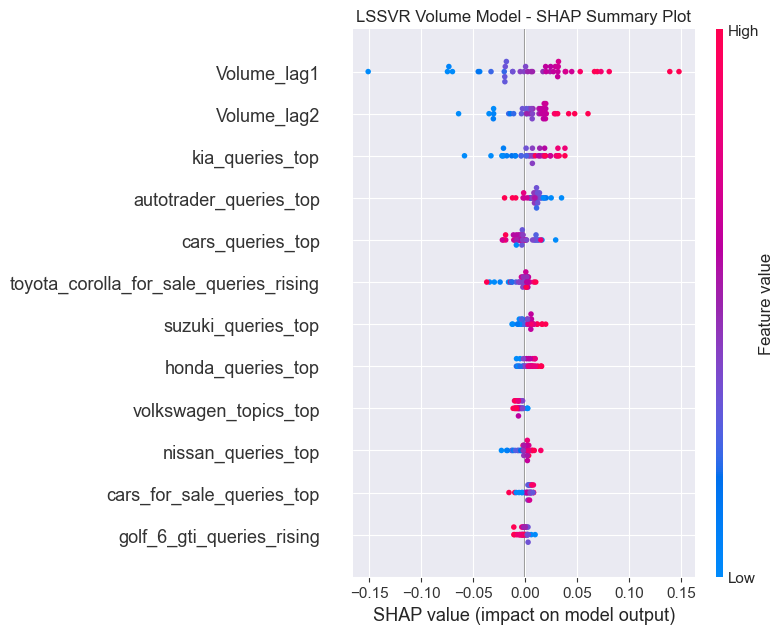

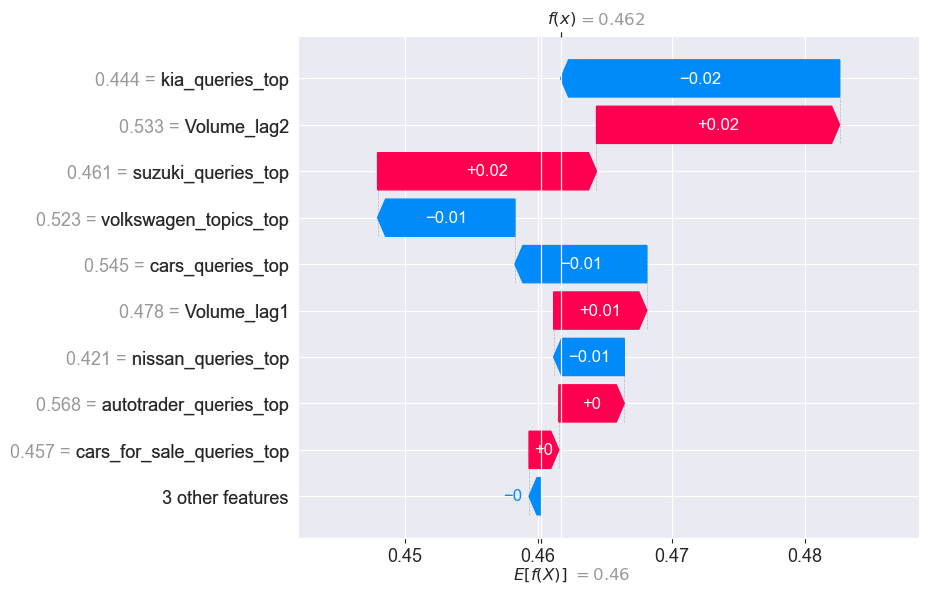

In [90]:
import shap
import matplotlib.pyplot as plt

# Assuming your model fits the sklearn API
# lssvr = trained LSSVR model

# Create SHAP Explainer
explainer_lssvr = shap.Explainer(lssvr.predict, X2_train_lagged)
shap_values_lssvr = explainer_lssvr(X2_test_lagged)

# Summary plot
shap.summary_plot(shap_values_lssvr, X2_test_lagged, show=False)
plt.title("LSSVR Volume Model - SHAP Summary Plot")
plt.show()

# Waterfall plot for a single prediction (example: first test instance)
index = 0
shap.plots.waterfall(shap_values_lssvr[index])


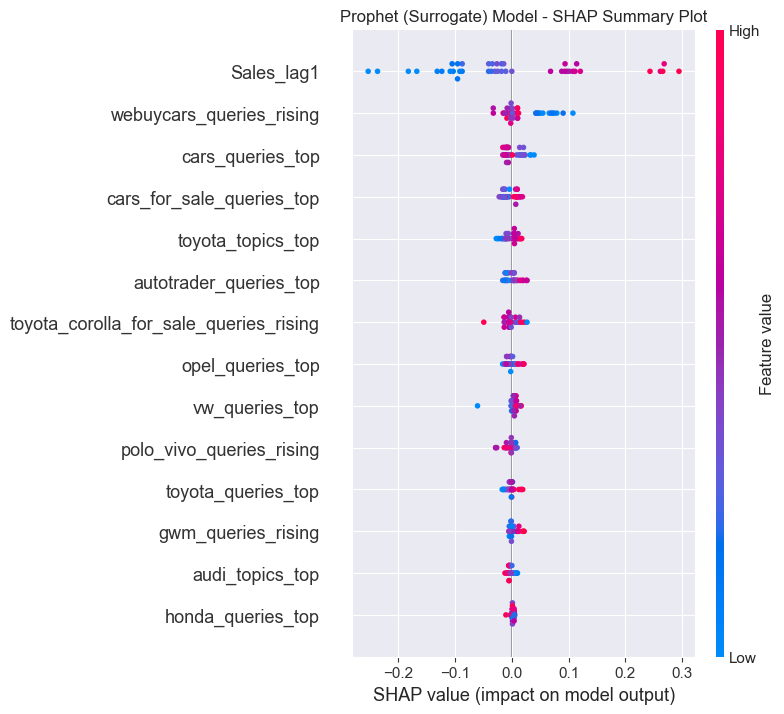

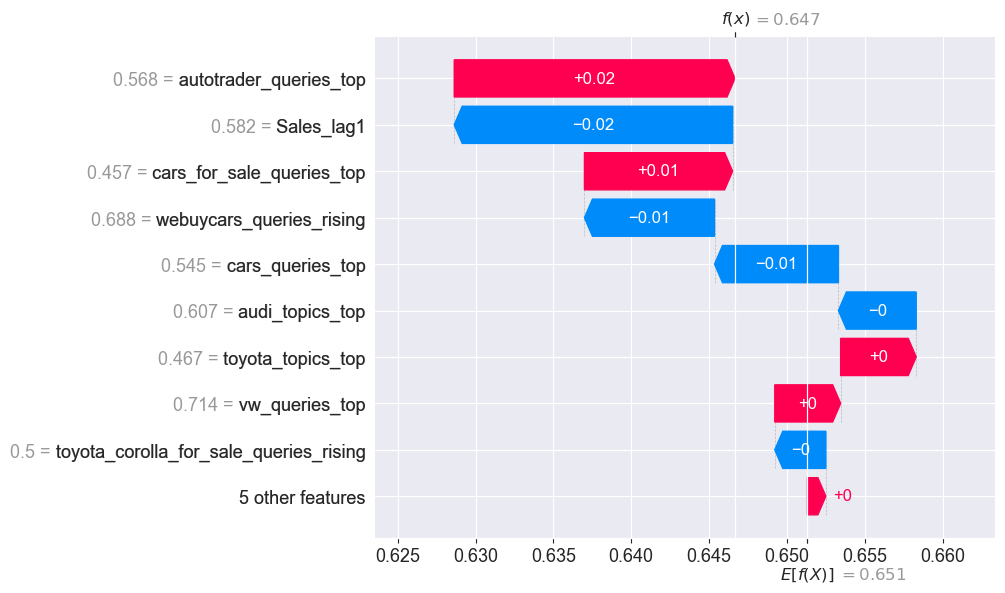

In [95]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

# Prophet model predictions
prophet_pred = prophet.predict(X1_test_lagged_2)

# Build a surrogate model
surrogate = GradientBoostingRegressor()
surrogate.fit(X1_train_lagged, y1_train_lagged)

# Create SHAP explainer for the surrogate
explainer_prophet = shap.Explainer(surrogate)
shap_values_prophet = explainer_prophet(X1_test_lagged)

# Summary plot
shap.summary_plot(shap_values_prophet, X1_test_lagged, show=False)
plt.title("Prophet (Surrogate) Model - SHAP Summary Plot")
plt.show()

# Waterfall plot for one example
index = 0
shap.plots.waterfall(shap_values_prophet[index])
